# Fictitious Play Agent Training and Saving Pipeline

This notebook trains Fictitious Play (FP) agents for a variety of simultaneous games.
For each game, it:
1. Initializes the game environment and FP agents.
2. Trains the agents by having them play against each other for a specified number of episodes/iterations, during which they update their counts of observed opponent actions.
3. Saves the learned action counts for each agent.
4. Saves the training data (e.g., average rewards per iteration) for later analysis.

The saved models (action counts) and data will be stored in the `fp_trainings` directory, organized by game.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import time # For potential rendering delays

# Game implementations
from games.rps import RPS
from games.mp import MP
from games.blotto import Blotto
from games.foraging import Foraging

# Agent implementation
from agents.fictitiousplay_t import FictitiousPlay 

# Base classes
from base.game import SimultaneousGame, AgentID, ActionDict

## 1. Define Games and Configurations

Specify the games to be tested and their respective configurations.
The `get_game_instance` helper function will be used to create game objects.

In [2]:
games_to_test = [
    {"name": "RPS", "game_class": RPS, "config": {}, "num_iterations": 500, "episodes_per_iteration": 200},
    {"name": "MP", "game_class": MP, "config": {}, "num_iterations": 500, "episodes_per_iteration": 200},
    {"name": "Blotto_S3_N2", "game_class": Blotto, "config": {"S": 3, "N": 2}, "num_iterations": 1000, "episodes_per_iteration": 200},
    {"name": "Foraging_5x5_2p_1f", "game_class": Foraging, "config": {"config": "Foraging-5x5-2p-1f-v3", "seed": 42}, "num_iterations": 500, "episodes_per_iteration": 50} 
]

def get_game_instance(game_entry: dict) -> SimultaneousGame:
    """Creates a game instance from a game entry."""
    game_class = game_entry["game_class"]
    config = game_entry["config"]
    if game_entry["name"].startswith("Blotto"):
        return game_class(**config)
    elif game_entry["name"].startswith("Foraging"):
        # Foraging takes 'config' string and 'seed' separately if seed is in game_entry["config"]
        return game_class(config=config.get("config"), seed=config.get("seed"))
    else:
        return game_class()

# Directory to save training outputs
TRAINING_DATA_DIR = "fp_trainings"
if not os.path.exists(TRAINING_DATA_DIR):
    os.makedirs(TRAINING_DATA_DIR)
    print(f"Created directory: {TRAINING_DATA_DIR}")
else:
    print(f"Directory already exists: {TRAINING_DATA_DIR}")

Directory already exists: fp_trainings


## 2. Helper Functions for Agent Creation, Training, and Saving

In [3]:
def create_agents(game: SimultaneousGame, initial_counts_dict: dict[AgentID, dict] = None, seed_base: int = None) -> dict[AgentID, FictitiousPlay]:
    """Creates FictitiousPlay agents for all agents in the game."""
    agents = {}
    for i, agent_id in enumerate(game.agents):
        agent_seed = seed_base + i if seed_base is not None else None
        initial_agent_counts = None
        if initial_counts_dict and agent_id in initial_counts_dict:
            initial_agent_counts = initial_counts_dict[agent_id]
            
        agents[agent_id] = FictitiousPlay(
            game=game, 
            agent=agent_id, 
            initial=initial_agent_counts, # Pass the specific counts for this agent if available
            seed=agent_seed
        )
    return agents

def play_episode_and_update(game: SimultaneousGame, agents: dict[AgentID, FictitiousPlay], max_steps_per_episode=100, verbose=False, render=False):
    """Plays a single episode, allowing agents to update their counts."""
    game.reset()
    # For FictitiousPlay, agent reset is mainly about internal state if any, but FP learns continuously.
    # The game.reset() is crucial.

    cumulative_rewards = {agent_id: 0.0 for agent_id in game.agents}
    is_foraging = isinstance(game, Foraging)
    
    for step in range(max_steps_per_episode):
        if is_foraging and game.env.unwrapped._game_over:
            if verbose: print(f"  Episode ended: Foraging game over.")
            break
        if not is_foraging and all(game.terminations.values()): # For matrix games
            if verbose: print(f"  Episode ended: All agents terminated (matrix game).")
            break

        actions = {agent_id: agents[agent_id].action() for agent_id in game.agents if not game.terminations[agent_id]}
        
        if not actions: # All agents might be terminated
            if verbose: print(f"  Episode ended: No actions to take (all agents terminated).")
            break

        game.step(actions) 

        # All agents update their beliefs based on the joint action observed
        for agent_id in game.agents:
            agents[agent_id].update() 
            cumulative_rewards[agent_id] += game.reward(agent_id)

        if verbose:
            print(f"  Step {step}: Actions: {actions}, Rewards: { {a: game.reward(a) for a in game.agents} }")
        
        if render:
            game.render()
            time.sleep(0.1)
            
        if all(game.terminations.values()) or (is_foraging and game.env.unwrapped._game_over):
            if verbose: print(f"  Episode ended: Termination condition met post-step.")
            break
            
    return cumulative_rewards


def train_agents_for_game(game: SimultaneousGame, agents: dict[AgentID, FictitiousPlay], num_iterations: int, episodes_per_iteration: int, max_steps_per_episode=100):
    """Trains FP agents by playing episodes and allowing them to update counts."""
    print(f"Starting Fictitious Play training for {game.__class__.__name__}...")
    
    all_iterations_average_rewards = {agent_id: [] for agent_id in game.agents}

    for i in range(1, num_iterations + 1):
        iteration_total_rewards = {agent_id: 0.0 for agent_id in game.agents}
        for ep in range(episodes_per_iteration):
            episode_rewards = play_episode_and_update(game, agents, max_steps_per_episode=max_steps_per_episode, verbose=False)
            for agent_id in game.agents:
                iteration_total_rewards[agent_id] += episode_rewards[agent_id]
        
        for agent_id in game.agents:
            avg_reward_iteration = iteration_total_rewards[agent_id] / episodes_per_iteration
            all_iterations_average_rewards[agent_id].append(avg_reward_iteration)

        if i % (num_iterations // 10 or 1) == 0:
            print(f"  Iteration {i}/{num_iterations} completed.")
            for agent_id in game.agents:
                print(f"    Agent {agent_id}: Avg Reward in iteration = {all_iterations_average_rewards[agent_id][-1]:.2f}")
                # Optionally, print some info about agent's beliefs (e.g., policy for one opponent)
                # if len(agents[agent_id].learned_policy) > 0:
                #     first_other_agent = next(iter(agents[agent_id].learned_policy.keys()))
                #     print(f"      Agent {agent_id}'s learned policy for {first_other_agent}: {np.round(agents[agent_id].learned_policy[first_other_agent], 2)}")

    print(f"Training completed for {game.__class__.__name__}.")
    return all_iterations_average_rewards


def save_agent_fp_data(agent: FictitiousPlay, game_name: str, agent_id_str: str, base_path: str):
    """Saves the action counts of an FP agent to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
    
    # agent.count is a dict: {other_agent_id: counts_array_for_other_agent_actions}
    # This is what the agent has learned.
    data_to_save = agent.count 
    file_path = os.path.join(game_specific_path, f"agent_{agent_id_str}_fp_counts.pkl")
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"  Saved FP counts for agent {agent_id_str} to {file_path}")
    except Exception as e:
        print(f"  Error saving FP counts for agent {agent_id_str}: {e}")

def save_fp_training_history(data: dict, game_name: str, base_path: str, filename="fp_training_rewards.pkl"):
    """Saves training history (e.g., rewards) to a file."""
    game_specific_path = os.path.join(base_path, game_name)
    if not os.path.exists(game_specific_path):
        os.makedirs(game_specific_path)
        
    file_path = os.path.join(game_specific_path, filename)
    try:
        with open(file_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"  Saved FP training history for {game_name} to {file_path}")
    except Exception as e:
        print(f"  Error saving FP training history for {game_name}: {e}")


## 3. Main Training Loop

Iterate through each game, train the Fictitious Play agents, and save their learned counts and the training history.

In [4]:
# Max steps per episode can vary by game.
GAME_MAX_STEPS = {
    "RPS": 1,
    "MP": 1,
    "Blotto_S3_N2": 1,
    "Foraging_5x5_2p_1f": 200 
}

BASE_SEED = 42 # For reproducibility of agent initialization if seeds are used

for game_entry in games_to_test:
    game_name = game_entry["name"]
    print(f"--- Training Fictitious Play for game: {game_name} ---")

    game_instance = get_game_instance(game_entry)
    
    # Create fresh agents for this game
    # The FictitiousPlay agent's 'seed' parameter in its constructor is used for its internal np.random if needed (e.g. tie-breaking in bestresponse)
    agents = create_agents(game_instance, seed_base=BASE_SEED)

    num_iter = game_entry["num_iterations"]
    ep_per_iter = game_entry["episodes_per_iteration"]
    max_steps = GAME_MAX_STEPS.get(game_name, 100) # Default if not specified

    training_rewards_history = train_agents_for_game(
        game_instance, 
        agents, 
        num_iterations=num_iter,
        episodes_per_iteration=ep_per_iter,
        max_steps_per_episode=max_steps
    )

    # Save agent counts and training history
    save_fp_training_history(training_rewards_history, game_name, TRAINING_DATA_DIR)
    for agent_id, agent_obj in agents.items():
        agent_id_simple = str(game_instance.agent_name_mapping[agent_id]) # e.g., "0", "1"
        save_agent_fp_data(agent_obj, game_name, agent_id_simple, TRAINING_DATA_DIR)
        
    print(f"--- Finished training and saving for {game_name} ---")

print("\nAll Fictitious Play training processes completed.")

--- Training Fictitious Play for game: RPS ---
Starting Fictitious Play training for RPS...
  Iteration 50/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.05
    Agent agent_1: Avg Reward in iteration = -0.05
  Iteration 100/500 completed.
    Agent agent_0: Avg Reward in iteration = -0.06
    Agent agent_1: Avg Reward in iteration = 0.06
  Iteration 150/500 completed.
    Agent agent_0: Avg Reward in iteration = -0.78
    Agent agent_1: Avg Reward in iteration = 0.78
  Iteration 200/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.64
    Agent agent_1: Avg Reward in iteration = -0.64
  Iteration 250/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.92
    Agent agent_1: Avg Reward in iteration = -0.92
  Iteration 300/500 completed.
    Agent agent_0: Avg Reward in iteration = 1.00
    Agent agent_1: Avg Reward in iteration = -1.00
  Iteration 350/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.06
    Agent agent_1: Avg Reward in ite

/opt/homebrew/Caskroom/miniconda/base/envs/py311/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:245: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


  Iteration 50/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.44
    Agent agent_1: Avg Reward in iteration = 0.20
  Iteration 100/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.48
    Agent agent_1: Avg Reward in iteration = 0.18
  Iteration 150/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.32
    Agent agent_1: Avg Reward in iteration = 0.36
  Iteration 200/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.46
    Agent agent_1: Avg Reward in iteration = 0.32
  Iteration 250/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.46
    Agent agent_1: Avg Reward in iteration = 0.28
  Iteration 300/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.48
    Agent agent_1: Avg Reward in iteration = 0.38
  Iteration 350/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.44
    Agent agent_1: Avg Reward in iteration = 0.22
  Iteration 400/500 completed.
    Agent agent_0: Avg Reward in iteration = 0.44
   

## 4. Plotting Training Results (Example)

This section demonstrates how to load and plot the saved training data (average rewards per iteration).

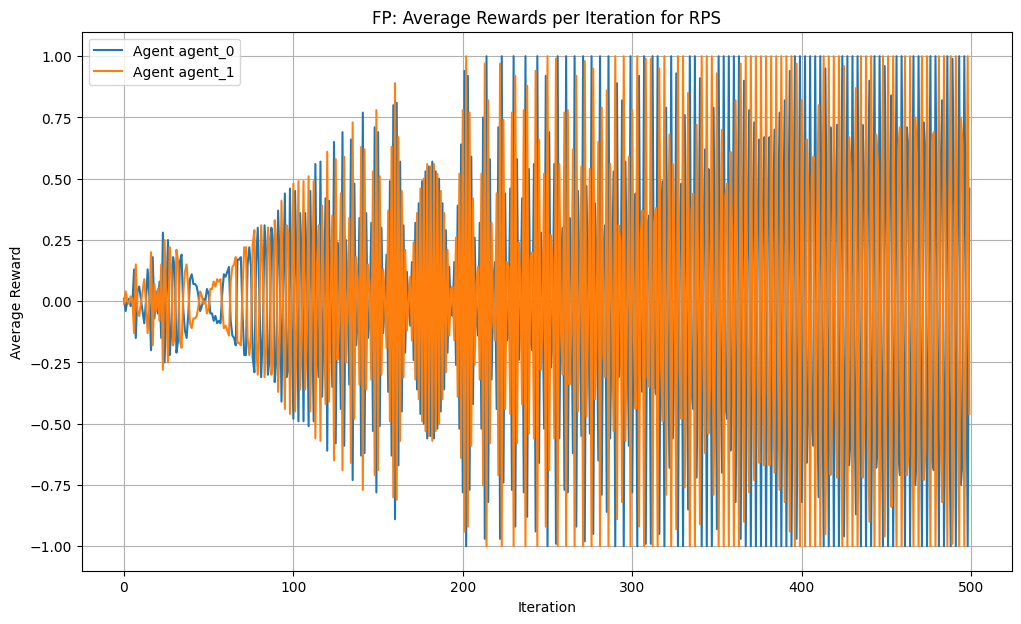

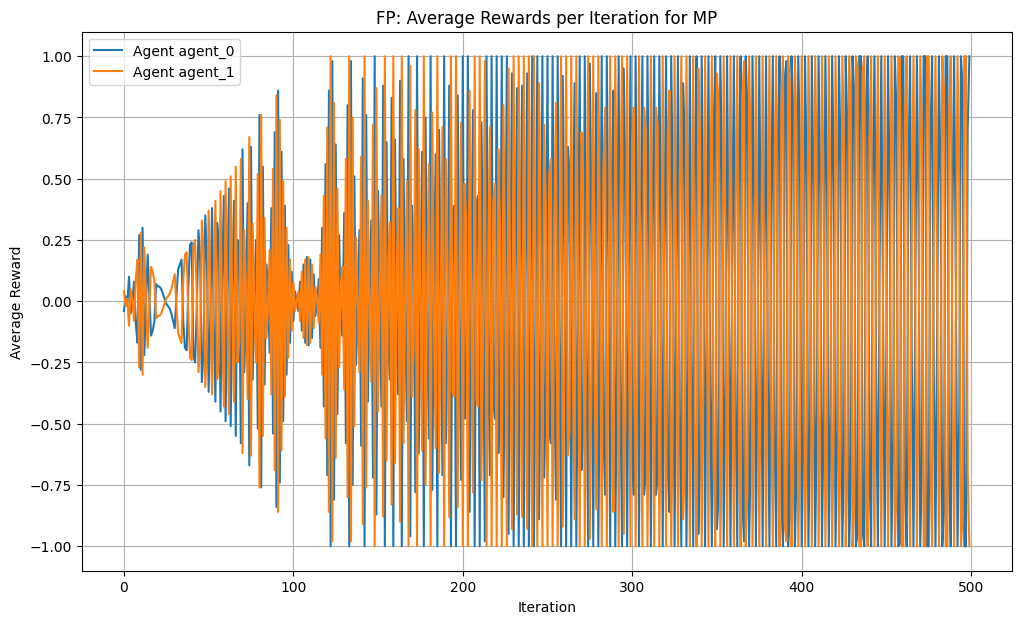

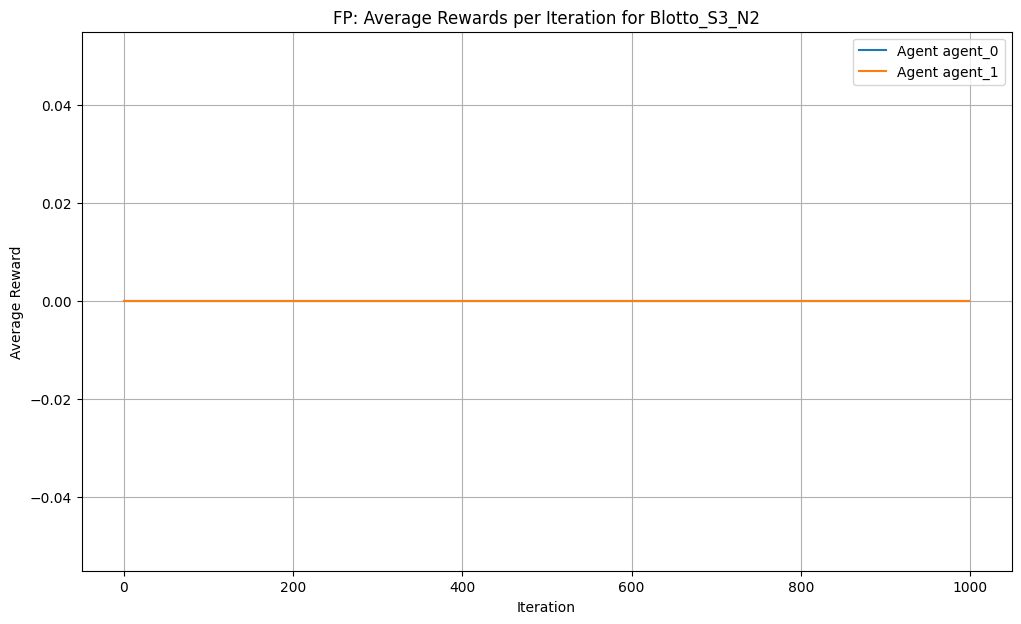

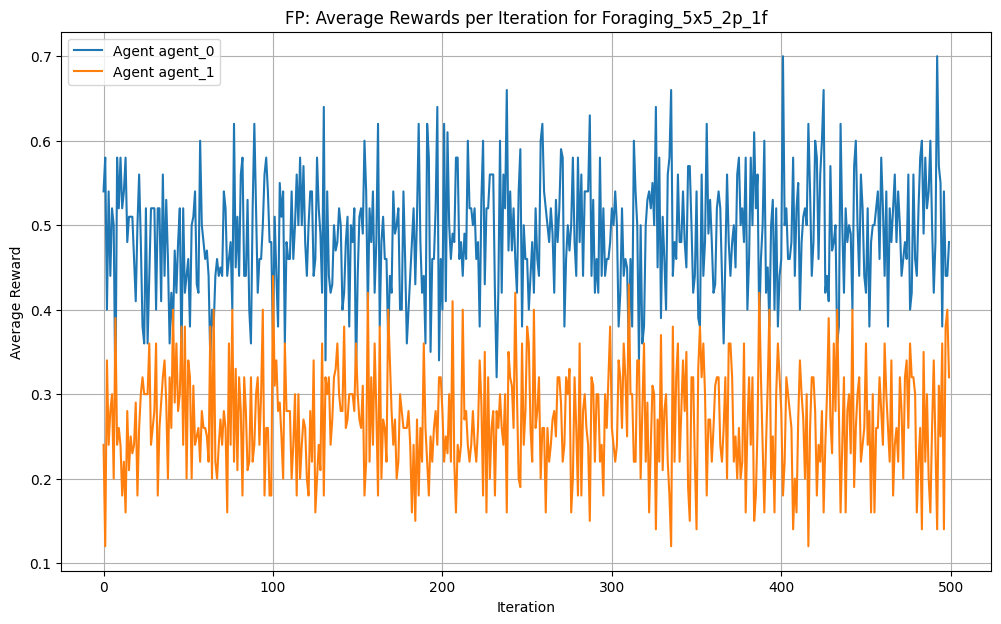

In [7]:
def plot_fp_training_results(game_name, base_path):
    data_path = os.path.join(base_path, game_name, "fp_training_rewards.pkl")
    if not os.path.exists(data_path):
        print(f"No FP training data found for {game_name} at {data_path}")
        return

    with open(data_path, 'rb') as f:
        training_rewards = pickle.load(f)

    plt.figure(figsize=(12, 7))
    for agent_id_str, rewards_list in training_rewards.items():
        # If agent_id_str is like 'agent_0', map it to a simpler name if needed
        label = f"Agent {agent_id_str}"
        # Try to get the mapped name if game_instance is available, or use agent_id_str
        # For simplicity, using the key from the dictionary directly.
        plt.plot(rewards_list, label=label)
    
    plt.title(f"FP: Average Rewards per Iteration for {game_name}")
    plt.xlabel("Iteration")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

if games_to_test:
    first_game_name_fp = games_to_test[0]["name"]
    plot_fp_training_results(first_game_name_fp, TRAINING_DATA_DIR)

    second_game_name_fp = games_to_test[1]["name"]
    plot_fp_training_results(second_game_name_fp, TRAINING_DATA_DIR)

    third_game_name_fp = games_to_test[2]["name"]
    plot_fp_training_results(third_game_name_fp, TRAINING_DATA_DIR)

    fourth_game_name_fp = games_to_test[3]["name"]
    plot_fp_training_results(fourth_game_name_fp, TRAINING_DATA_DIR)
    

## 5. Loading Trained Fictitious Play Agents (Example)

This section shows how to load the saved action counts back into `FictitiousPlay` agents.
This would typically be done in a separate notebook for testing or deployment.
The `initial` parameter of the `FictitiousPlay` agent's constructor is used for this.

In [6]:
def load_agent_fp_data(game: SimultaneousGame, agent_id_to_load: AgentID, game_name: str, agent_id_str: str, base_path: str, seed: int = None) -> FictitiousPlay | None:
    """Loads action counts for an agent and re-initializes it."""
    file_path = os.path.join(base_path, game_name, f"agent_{agent_id_str}_fp_counts.pkl")
    if not os.path.exists(file_path):
        print(f"  No FP counts file found for agent {agent_id_str} in {game_name} at {file_path}")
        return None
    
    try:
        with open(file_path, 'rb') as f:
            # This loaded_counts is the dictionary `agent.count` which was saved.
            # It contains {other_agent_id: counts_for_other_agent_actions, ...}
            loaded_counts = pickle.load(f) 
        
        # Re-create the agent, passing the loaded counts to its 'initial' parameter.
        # The FictitiousPlay agent's __init__ method will use these counts to initialize
        # its internal self.count and self.learned_policy.
        agent = FictitiousPlay(game=game, agent=agent_id_to_load, initial=loaded_counts, seed=seed)
        print(f"  Loaded FP counts for agent {agent_id_str} from {file_path} into a new agent instance.")
        return agent
    except Exception as e:
        print(f"  Error loading FP counts for agent {agent_id_str}: {e}")
        return None

# Example of how you might load agents for a specific game:
# print("\n--- Example: Loading trained FP agents for RPS ---")
# rps_game_load_example = RPS() 
# loaded_fp_agents = {}

# for agent_id_key in rps_game_load_example.agents: # e.g., "agent_0", "agent_1"
#     agent_id_simple_load = str(rps_game_load_example.agent_name_mapping[agent_id_key]) # "0", "1"
    
#     # Create a new agent instance with the loaded counts
#     loaded_agent = load_agent_fp_data(
#         game=rps_game_load_example,
#         agent_id_to_load=agent_id_key,
#         game_name="RPS", 
#         agent_id_str=agent_id_simple_load, 
#         base_path=TRAINING_DATA_DIR,
#         seed=100 # Optional seed for the loaded agent
#     )
#     if loaded_agent:
#         loaded_fp_agents[agent_id_key] = loaded_agent

# if loaded_fp_agents:
#     print("Successfully loaded FP agents for RPS.")
    # Now loaded_fp_agents would contain agents with their learned counts, ready for evaluation.
    # You could then run play_episode_and_update (or a similar evaluation function)
    # e.g., eval_rewards = play_episode_and_update(rps_game_load_example, loaded_fp_agents, verbose=True)
    # print(f"Evaluation rewards with loaded FP agents: {eval_rewards}")
